In [41]:
import numpy as np
import pandas as pd
import h5py
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [66]:
df_training = pd.read_hdf('./NSubjetiness_TopData/train_subjettiness.h5', key='table')
df_val = pd.read_hdf('./NSubjetiness_TopData/val_subjettiness.h5', key='table')
df_test = pd.read_hdf('./NSubjetiness_TopData/test_subjettiness.h5', key='table')
keys = df_training.keys()

In [67]:
mean_values = []
std_values = []
for k in range(27):
    mean_values.append(np.mean(df_training[keys[k]]))
    std_values.append(np.std(df_training[keys[k]]))
    df_training[keys[k]] = (df_training[keys[k]] - mean_values[k]) / std_values[k]
    df_val[keys[k]] = (df_val[keys[k]] - mean_values[k]) / std_values[k]
    df_test[keys[k]] = (df_test[keys[k]] - mean_values[k]) / std_values[k]

In [68]:
def removeNaN(df):
    for i in range(len(df)):
        if(i % 5000 == 0):
            print(i / len(df) * 100)
        for j in range(len(keys)):
            if not df.iloc[i][j] == df.iloc[i][j]:
                print("yes", i, j)
                df.drop(df.index[i], inplace=True)

In [ ]:
#removeNaN(df_training)
#removeNaN(df_val)
removeNaN(df_test)

In [69]:
df_training.drop(df_training.index[456856], inplace=True)
df_val.drop(df_val.index[199765], inplace=True)

In [70]:
print(keys)

Index(['1_subjettiness_0.5', '1_subjettiness_1.0', '1_subjettiness_2.0',
       '2_subjettiness_0.5', '2_subjettiness_1.0', '2_subjettiness_2.0',
       '3_subjettiness_0.5', '3_subjettiness_1.0', '3_subjettiness_2.0',
       '4_subjettiness_0.5', '4_subjettiness_1.0', '4_subjettiness_2.0',
       '5_subjettiness_0.5', '5_subjettiness_1.0', '5_subjettiness_2.0',
       '6_subjettiness_0.5', '6_subjettiness_1.0', '6_subjettiness_2.0',
       '7_subjettiness_0.5', '7_subjettiness_1.0', '7_subjettiness_2.0',
       '8_subjettiness_0.5', '8_subjettiness_1.0', '8_subjettiness_2.0', 'm',
       'pT', 'truthE', 'truthPX', 'truthPY', 'truthPZ', 'ttv',
       'is_signal_new'],
      dtype='object')


In [77]:
input_vec = df_training[keys[0:-7]]
training_input = torch.tensor(input_vec.values)
val_input = torch.tensor(df_val[keys[0:-7]].values)

labels = df_training[keys[-1]]
training_labels = torch.tensor(labels.values)
val_labels = torch.tensor(df_val[keys[-1]].values)

torch.reshape(training_labels, (len(training_labels), 1))
torch.reshape(val_labels, (len(val_labels), 1))

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

In [81]:
model = torch.nn.Sequential(
    torch.nn.Linear(25, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()

In [82]:
learning_rate = 0.04
epochs = 500

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epoch: 0, loss: 0.6998, accuracy: 0.5000, AUC: 0.2080
epoch: 50, loss: 0.6810, accuracy: 0.5015, AUC: 0.8775
epoch: 100, loss: 0.6487, accuracy: 0.7969, AUC: 0.8782
epoch: 150, loss: 0.5558, accuracy: 0.8176, AUC: 0.8845
epoch: 200, loss: 0.4269, accuracy: 0.8472, AUC: 0.9121
epoch: 250, loss: 0.3290, accuracy: 0.8905, AUC: 0.9416
epoch: 300, loss: 0.2755, accuracy: 0.9012, AUC: 0.9497
epoch: 350, loss: 0.2556, accuracy: 0.9037, AUC: 0.9534
epoch: 400, loss: 0.2464, accuracy: 0.9050, AUC: 0.9561
epoch: 450, loss: 0.2407, accuracy: 0.9057, AUC: 0.9583


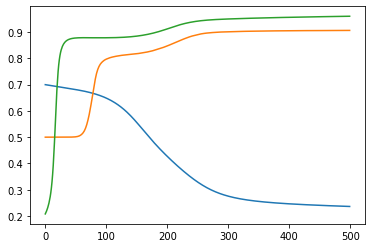

In [83]:
loss_arr = []
acc_arr = []
auc_arr = []
for e in range(epochs):
    label_pred = model(training_input)
    loss = loss_fn(label_pred, training_labels.reshape(-1, 1))
    val_pred = model(val_input)
    acc_arr.append(1 - torch.sum(torch.abs(model(val_input).round() - val_labels.reshape(-1, 1))).item()/len(val_labels))
    loss_arr.append(loss.item())
    auc_arr.append(roc_auc_score(val_labels.detach().numpy(), val_pred.detach().numpy()))
    if e % 50 == 0:
        print("epoch: %d, loss: %.4f, accuracy: %.4f, AUC: %.4f" % (e, loss.item(), acc_arr[e], auc_arr[e]))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
plt.plot(range(epochs), loss_arr)
plt.plot(range(epochs), acc_arr)
plt.plot(range(epochs), auc_arr)
plt.show()